**Upload Kaggle API Key JSON File (Run This Cell First, Then Run The Rest)**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sodijgdisjgoij","key":"035c735396cb74ec497f07ca970df9f6"}'}

**Download Files From Kaggle**

*Install Kaggle*

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*Moving Key to Correct Directory to Use Kaggle*

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/

*Download Shoe Dataset*

In [ ]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 43% 20.0M/47.0M [00:00<00:00, 96.7MB/s]
100% 47.0M/47.0M [00:00<00:00, 157MB/s] 


In [ ]:
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip && mv 'Shoe vs Sandal vs Boot Dataset' dataset

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

**Separating Images into Test, Validation, and Training Folders**

In [ ]:
from pathlib import Path
import random

random.seed(911911)

#get the file paths for each of the classes in /content/dataset
cDirectories = [ c for c in Path("/content/dataset").iterdir()]

#get all files
bootFiles = [boot for boot in Path("/content/dataset/Boot").iterdir()]
sandalFiles = [sandal for sandal in Path("/content/dataset/Sandal").iterdir()]
shoeFiles = [shoe for shoe in Path("/content/dataset/Shoe").iterdir()]

files = bootFiles + sandalFiles + shoeFiles

#randomize files
random.shuffle(files)

In [ ]:
#Create new destination folders
split = ["training", "validation", "testing"]
Path("/content/output").mkdir(parents=True, exist_ok=True)
for i in split:
  Path("/content/output/" +  i +"/Boot").mkdir(parents=True, exist_ok=True)
  Path("/content/output/" +  i +"/Sandal").mkdir(parents=True, exist_ok=True)
  Path("/content/output/" +  i +"/Shoe").mkdir(parents=True, exist_ok=True)


In [ ]:
import shutil

#Move files to new folders
trainNum = int(0.8* len(files))
testNum = int(0.1* len(files))
validNum = int(0.1* len(files))
count = 0
curFolder = split[0]
for file in files:
  if( count < trainNum ):
    curFolder = split[0]
  elif( count < trainNum + testNum ):
    curFolder = split[1]
  else:
    curFolder = split[2]
  shutil.move( str(file) , "/content/output/" + curFolder + "/" + file.parts[3])
  count = count + 1

**Imports**

In [ ]:
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

**Preprocessing**

*Setup Image Generators for Data Augmentation and Rescaling*

In [ ]:
trainGen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1/255.0,
  horizontal_flip=True,
  rotation_range=20,
)

testGen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1/255.0
)

*Specify Directory of Images, Resize, and Specify Batch Size*

In [ ]:
trainData = trainGen.flow_from_directory(
  '/content/output/training',
  target_size=(224, 224),
  batch_size=32,
  color_mode = "rgb",
  class_mode = "sparse"
)

validData = testGen.flow_from_directory(
  '/content/output/validation',
  target_size=(224, 224),
  batch_size=32,
  color_mode = "rgb",
  class_mode = "sparse"
)

testData = testGen.flow_from_directory(
  '/content/output/testing',
  target_size=(224, 224),
  batch_size=32,
  color_mode = "rgb",
  class_mode = "sparse",
  shuffle = False
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


*Examples of Augmented Images*

In [ ]:
image, label = next(trainData)
trainData.reset()

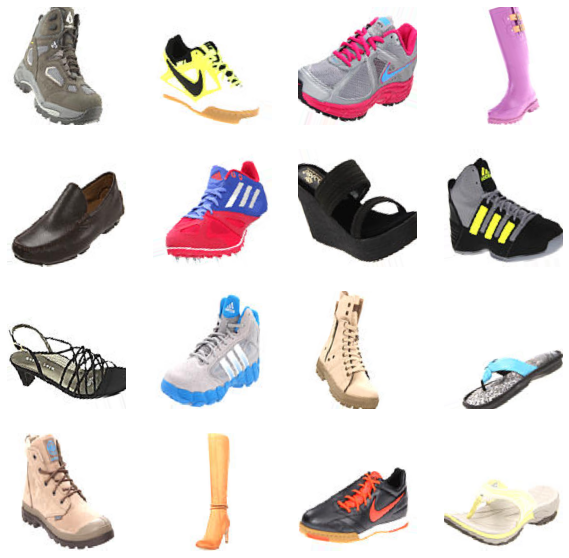

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(0, 16):
    img = image[i]
    fig.add_subplot(4, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()

**Model**

In [ ]:
model = Sequential()

model.add(Conv2D(input_shape = (224, 224, 3), filters = 16, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (3, 3), strides = (3, 3)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (3, 3), strides = (3, 3)))

model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 4096, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = 3, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_71 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 conv2d_73 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                 

In [ ]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy,
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=["accuracy"])

In [ ]:
history = model.fit(trainData, validation_data = validData, epochs = 15)
model.save("Catherine_VGGNet.h5")

Epoch 1/15
375/375 [==============================] - 131s 345ms/step - loss: 0.6368 - accuracy: 0.7081 - val_loss: 0.2831 - val_accuracy: 0.8787
Epoch 2/15
375/375 [==============================] - 130s 347ms/step - loss: 0.2757 - accuracy: 0.8965 - val_loss: 0.1780 - val_accuracy: 0.9307
Epoch 3/15
375/375 [==============================] - 130s 346ms/step - loss: 0.1903 - accuracy: 0.9314 - val_loss: 0.1412 - val_accuracy: 0.9467
Epoch 4/15
375/375 [==============================] - 130s 347ms/step - loss: 0.1563 - accuracy: 0.9450 - val_loss: 0.1486 - val_accuracy: 0.9460
Epoch 5/15
375/375 [==============================] - 129s 343ms/step - loss: 0.1253 - accuracy: 0.9572 - val_loss: 0.0971 - val_accuracy: 0.9667
Epoch 6/15
375/375 [==============================] - 128s 341ms/step - loss: 0.1114 - accuracy: 0.9622 - val_loss: 0.0903 - val_accuracy: 0.9680
Epoch 7/15
375/375 [==============================] - 129s 343ms/step - loss: 0.0968 - accuracy: 0.9662 - val_loss: 0.0823 -

**Visualization of Training and Validation Loss**

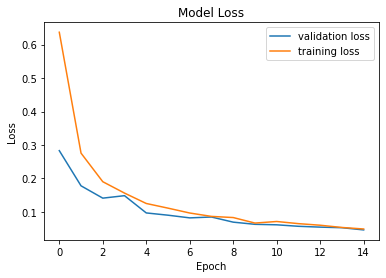

In [ ]:
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['validation loss', 'training loss'], loc='upper right')

**Visualization of Accuracy**

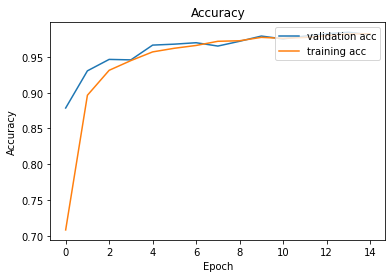

In [ ]:
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["accuracy"])
plt.title("Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['validation acc', 'training acc'], loc='upper right')

**Testing**

*Evaluating the Model with Test Data*

In [ ]:
result = model.evaluate(testData)

47/47 [==============================] - 3s 64ms/step - loss: 0.0451 - accuracy: 0.9833


*View of the Model's Predictions on a part of the Test Data*

In [ ]:
testData.reset()
labels = np.concatenate([testData.next()[1] for i in range(testData.__len__())])
images = np.concatenate([testData.next()[0] for i in range(testData.__len__())])
np.random.seed(420)
np.random.shuffle(labels)
np.random.seed(420)
np.random.shuffle(images)

47/47 [==============================] - 2s 27ms/step


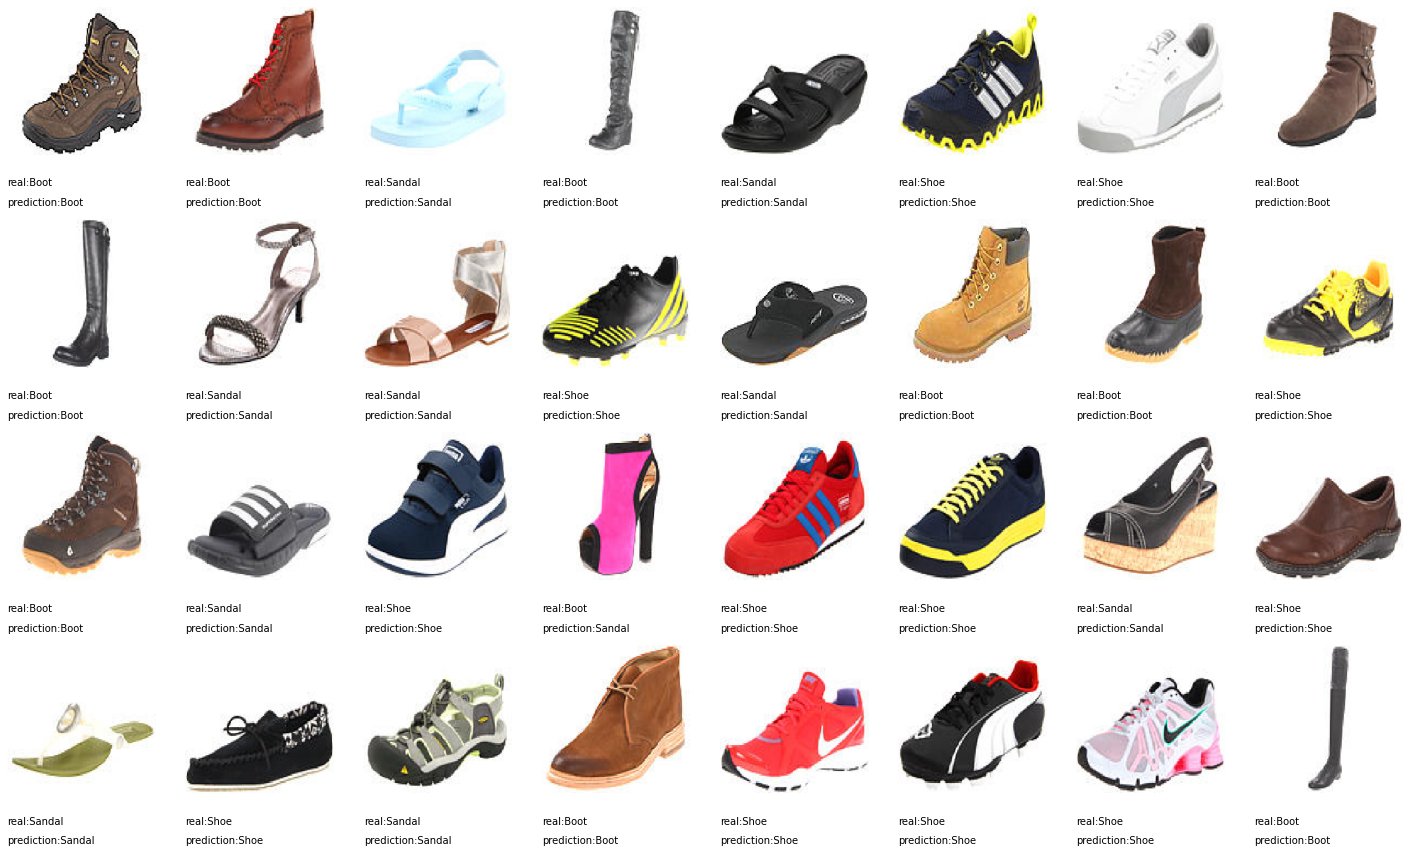

In [ ]:
softpred = model.predict(images)
pred = np.argmax(softpred, axis=1)

class_names = ["Boot", "Sandal", "Shoe"]
fig = plt.figure(figsize = (25,15))
for i in range(0, 32):
  img = images[i]
  fig.add_subplot(4,8, i+1)
  plt.imshow(img)
  plt.text(0,270,"real:" +class_names[int(labels[i])])
  plt.text(0,300, "prediction:" +class_names[pred[i]])
  plt.axis("off")
plt.show()

*View Misclassified Examples*

In [ ]:
testData.reset()
labels = np.concatenate([testData.next()[1] for i in range(testData.__len__())])
images = np.concatenate([testData.next()[0] for i in range(testData.__len__())])

In [ ]:
softpred = model.predict( images )
pred = np.argmax(softpred, axis = 1)

47/47 [==============================] - 1s 27ms/step


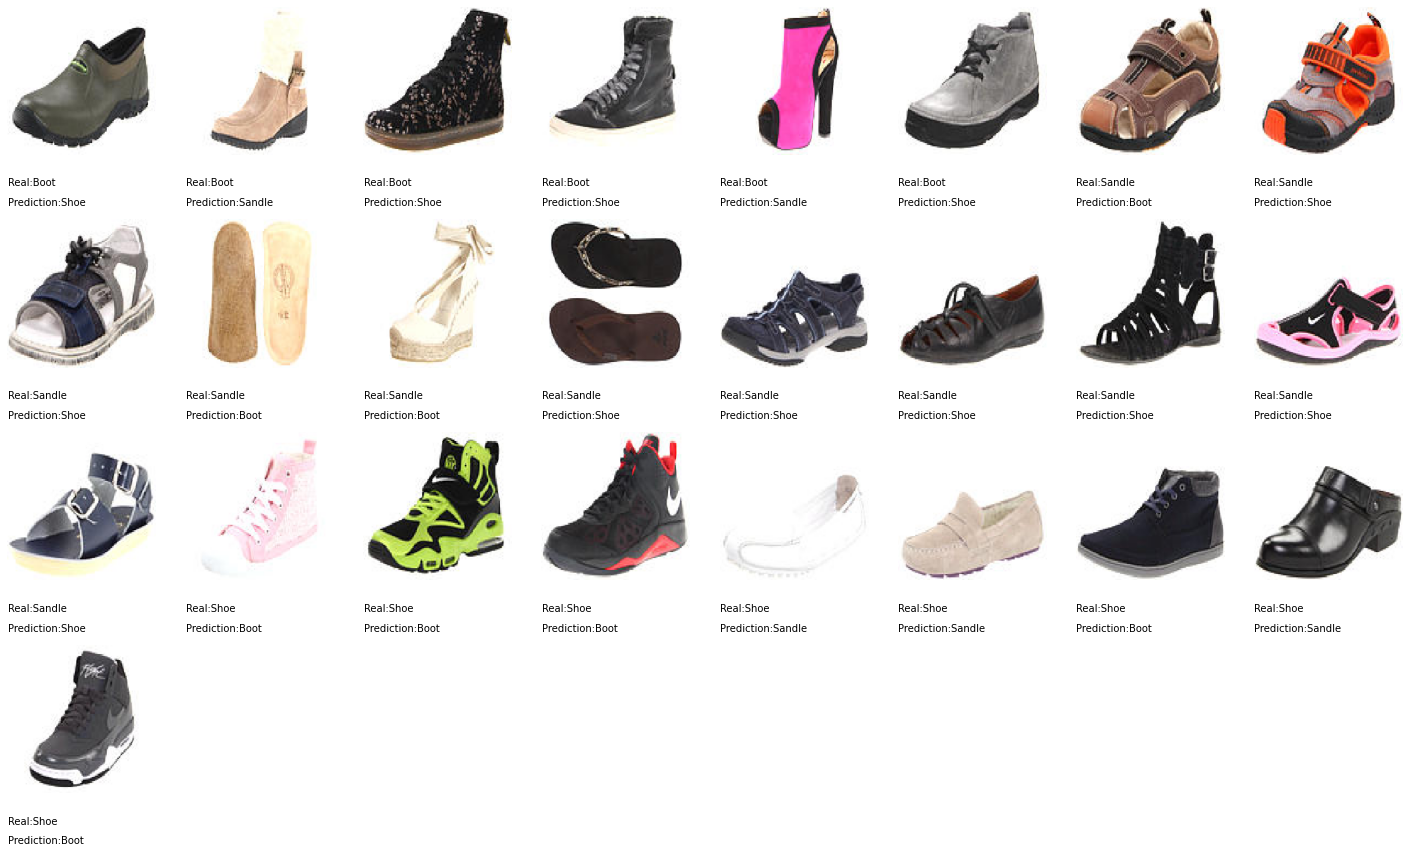

In [ ]:
class_names = ["Boot", "Sandle", "Shoe"]
fig = plt.figure(figsize=(25, 15))
count = 0;
passes = 0;
for i in range(0, 1500):
    img = images[i]
    labelPred = class_names[int(labels[i])]
    labelReal = class_names[pred[i]]
    if labelPred != labelReal:
      if count < 32:  
        fig.add_subplot(4, 8, count+1)
        plt.imshow(img)
        plt.text(0, 270, "Real:" + labelPred)
        plt.text(0, 300, "Prediction:" + labelReal)
        
        plt.axis("off")
      count+=1
plt.show()